# WorkChain化を行う。

In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

In [2]:
from aiida.engine import calcfunction,workfunction, WorkChain, ToContext, submit,run,while_
from aiida.orm import Str,Float, Dict, load_node
import numpy as np
from aiida.plugins import DataFactory

WorkChain化する。

daemonがsubmitするためにファイルのloadはabsolute pathが必要。

In [4]:
@calcfunction
def _load_poscar(element, absolute_path):
    import os
    symbol = element.value
    directory  = absolute_path.value
    from pymatgen.core.structure import Structure
    filename = "POSCAR."+symbol
    path = os.path.join(directory,filename)
    struc = Structure.from_file(path)
    StructureData = DataFactory("core.structure")
    structure = StructureData()
    structure.set_pymatgen(struc)
    return structure

@calcfunction
def _rescale_volume(structure, scale):
    """
    Workfunction to rescale a structure

    :param structure: An AiiDA structure to rescale
    :param scale: The scale factor (for the lattice constant)
    :return: The rescaled structure
    """
    the_ase = structure.get_ase()
    new_ase = the_ase.copy()
    new_ase.set_cell(the_ase.get_cell() * scale.value, scale_atoms=True)
    new_structure = DataFactory('core.structure')(ase=new_ase)

    struc = new_structure.get_pymatgen()
    return Float(struc.volume)

# This subroutine is important.
@calcfunction 
def _pack_calculations(**kwargs):
    print("pack",kwargs)
    result = [result for label, result in kwargs.items()]
    return Dict(dict={'volumes':result})

@calcfunction
def _volume_average(calculations):
    print("_volume_average.calculations", calculations)
    volumes = calculations["volumes"]
    volume_avg = np.average(volumes)
    print("volume_avg", volume_avg)
    return Float(volume_avg)

if False:
    @calcfunction
    def _average_volumes(**kwargs):
        print("pack",kwargs)
        volumes = [result.value for label, result in kwargs.items()]
        print("volumes",volumes)
        volume_avg = np.average(volumes)
        print("volume_avg", volume_avg)
        return Float(volume_avg)

class  RescaledStructuresVolume(WorkChain):
    @classmethod
    def define(cls, spec):
        super().define(spec)
        
        spec.input("element", valid_type=Str)
        ArrayData = DataFactory('core.array')
        spec.input("factor_array", valid_type=ArrayData)
        spec.input("absolute_path", valid_type=Str)
        spec.outline(cls.create_diamond_fcc,
                     cls.run_rescale_volume,
                     cls.volume_agv,
                    )
        spec.output("volume_avg",valid_type=Float)
        
    def create_diamond_fcc(self):
        element = self.inputs.element
        factor_array = self.inputs.factor_array
        absolute_path = self.inputs.absolute_path
        s0 = _load_poscar(element, absolute_path)
        # Carefully connect the intermediate data using self.ctx.
        self.ctx.s0 = s0 

    def run_rescale_volume(self):
        structure = self.ctx.s0
        calculations = {}
        factor_array = self.inputs.factor_array
        factors = factor_array.get_array("vector")        
        for i,factor in enumerate(factors):
            label = "iter{}".format(i)
            new_volume = _rescale_volume(structure, Float(factor))
            print(label,"new_volume",new_volume)
            calculations[label] = new_volume
        print("calculation",calculations)
        inputs = {
            label: result
            for label, result in calculations.items()
        }
        self.ctx.calculations = _pack_calculations(**inputs)
    
    def volume_agv(self):
        calculations = self.ctx.calculations
        print("calculations2", calculations)
        result = _volume_average(calculations)
        print("result",result)
        # output is set by self.out()
        self.out("volume_avg", result)

In [5]:
        
# define inputs
def define_inputs():
    element = Str("Si")
    element.store()
    print("element.pk",element.pk)

    factor_list = [0.98, 0.99, 1.0, 1.1, 1.2]
    ArrayData = DataFactory('array')
    factor_array = ArrayData()
    factor_array.set_array("vector",np.array(factor_list))
    return element, factor_array
    
# run
element, factor_array = define_inputs()
import os
absolute_path = Str(os.getcwd())
result, node = run.get_node(RescaledStructuresVolume, element=element,
             factor_array=factor_array, absolute_path=absolute_path)
result

element.pk 9746
iter0 new_volume uuid: 1e4ef59a-1418-4a79-88d2-f9227530fca5 (pk: 9754) value: 37.692734388326
iter1 new_volume uuid: ae516edb-dc41-4149-b009-021de2531d05 (pk: 9757) value: 38.858407725797
iter2 new_volume uuid: 5be0592e-06c4-4c7f-ab8a-1dca21a25bd1 (pk: 9760) value: 40.04786949775
iter3 new_volume uuid: f10023a6-5b8f-4cf0-bd9f-3dd26bb9203b (pk: 9763) value: 53.303714301505
iter4 new_volume uuid: 6e59783c-f3cc-44fe-a953-fa81cd48998c (pk: 9766) value: 69.202718492112
calculation {'iter0': <Float: uuid: 1e4ef59a-1418-4a79-88d2-f9227530fca5 (pk: 9754) value: 37.692734388326>, 'iter1': <Float: uuid: ae516edb-dc41-4149-b009-021de2531d05 (pk: 9757) value: 38.858407725797>, 'iter2': <Float: uuid: 5be0592e-06c4-4c7f-ab8a-1dca21a25bd1 (pk: 9760) value: 40.04786949775>, 'iter3': <Float: uuid: f10023a6-5b8f-4cf0-bd9f-3dd26bb9203b (pk: 9763) value: 53.303714301505>, 'iter4': <Float: uuid: 6e59783c-f3cc-44fe-a953-fa81cd48998c (pk: 9766) value: 69.202718492112>}
pack {'iter0': <Float: 

{'volume_avg': <Float: uuid: 6bf5ff44-8f48-4104-9f05-e3a86c916f17 (pk: 9770) value: 47.821088881098>}

In [6]:
pk = result["volume_avg"].pk
pk

9770

Success: Output written to `9770.dot.pdf`


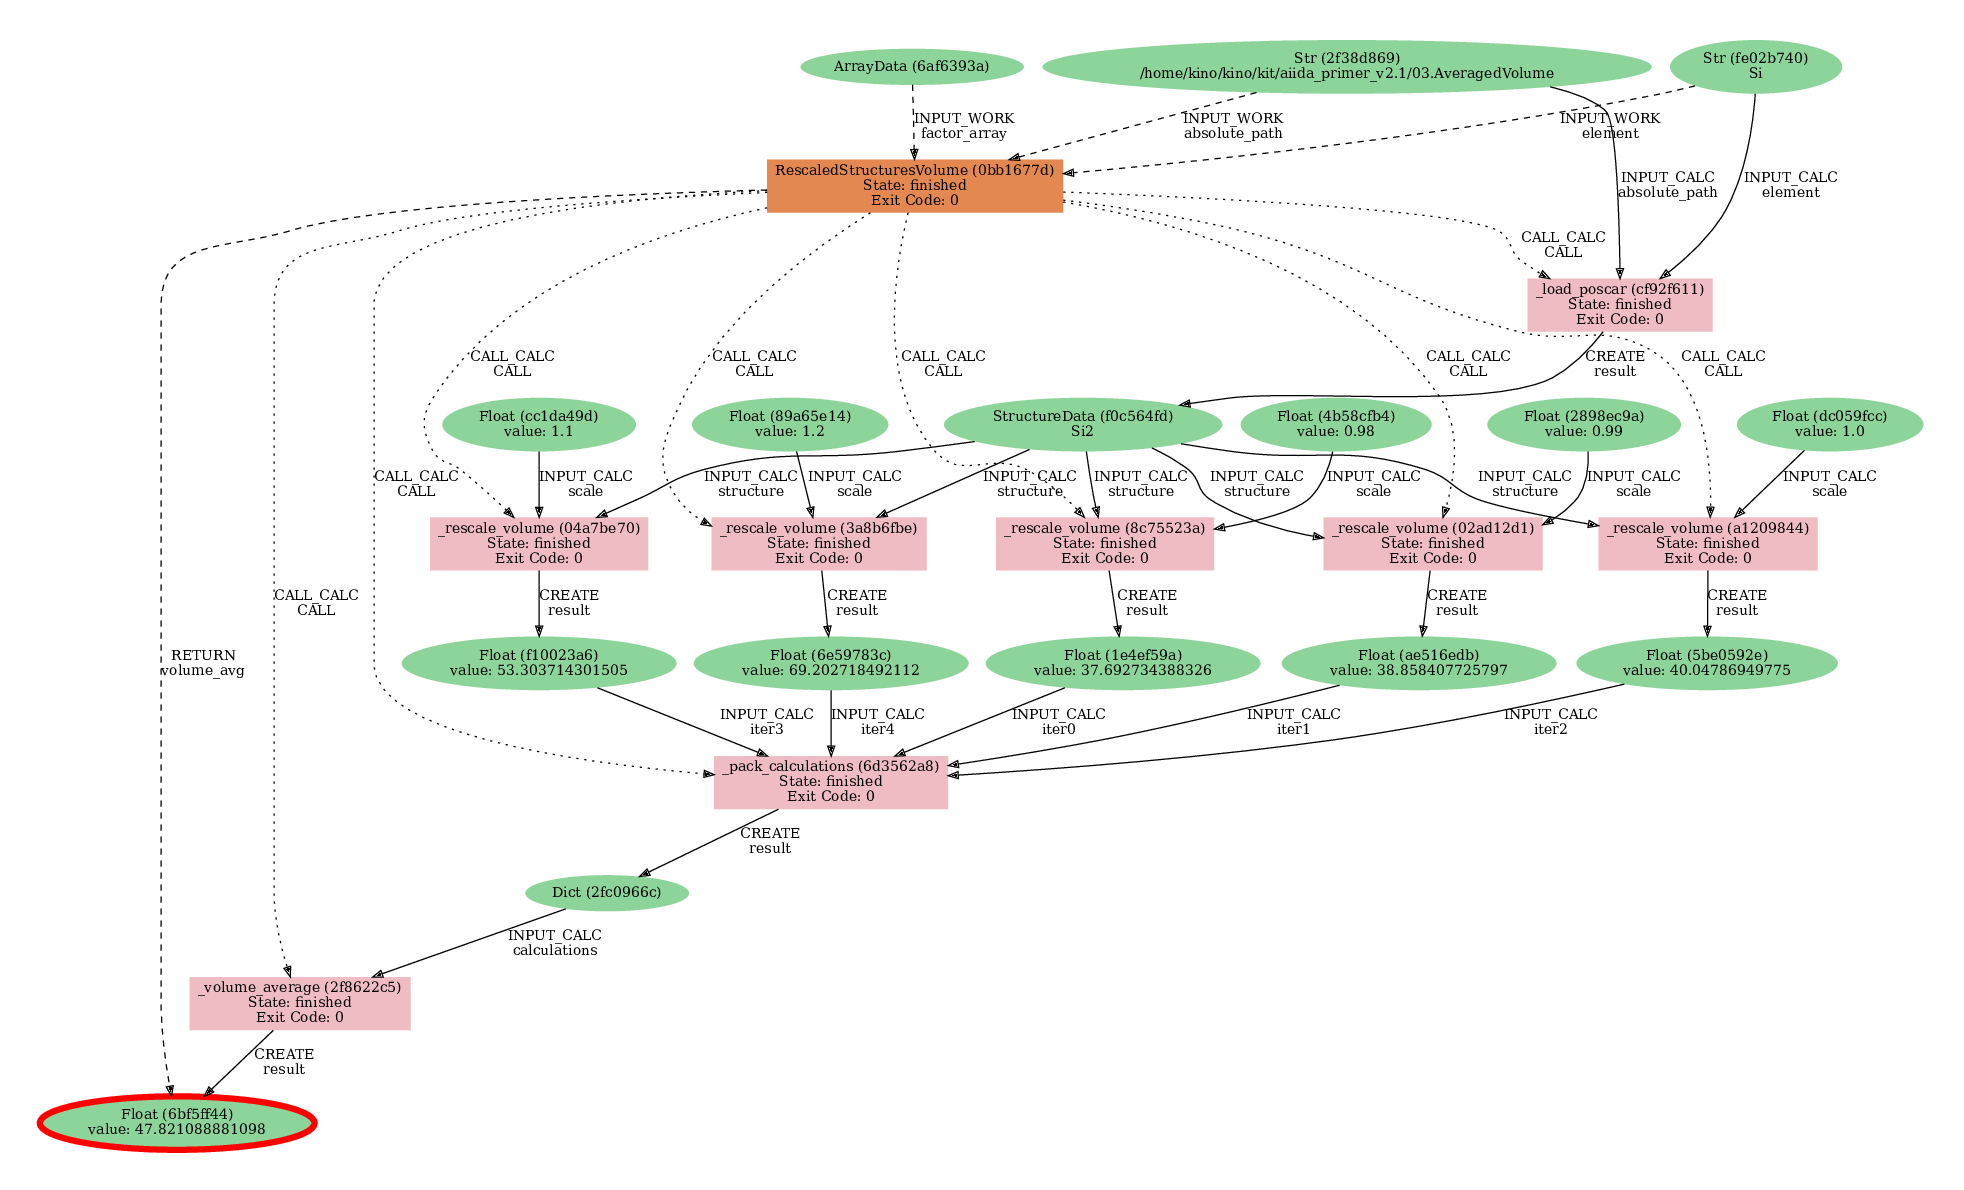

In [7]:
import subprocess
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))